### Repeat the import actions from the previous [notebook](feature_analysis.ipynb)

In [1]:
# Command specified for nanohub user, enable lammps executable
# import hublib.use
# %use lammps-03Mar20

# Check the path of executable
from monty.os.path import which
which("lmp_serial")

'/srv/conda/envs/notebook/bin/lmp_serial'

In [2]:
# general imports
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from monty.serialization import loadfn
from maml.utils import pool_from, convert_docs

# local environment descriptors imports
from maml.describers import BispectrumCoefficients
from sklearn.decomposition import PCA

# machine learning interatomic potentials imports
from maml.base import SKLModel
from maml.apps.pes import SNAPotential
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression

# materials properties prediction imports
from pymatgen import Structure, Lattice
from maml.apps.pes import LatticeConstant, ElasticConstant, NudgedElasticBand, DefectFormation

# disable logging information
import logging
logging.disable(logging.CRITICAL)

### Repeat the load actions from previous [notebook](feature_analysis.ipynb)

In [3]:
Mo_aimd_nvt_data = loadfn('./data/Mo/AIMD_NVT.json')
Mo_aimd_npt_data = loadfn('./data/Mo/AIMD_NPT.json')
Mo_elastic_data = loadfn('./data/Mo/Elastic.json')
Mo_surface_data = loadfn('./data/Mo/Surface.json')
Mo_vacancy_data = loadfn('./data/Mo/Vacancy.json')
Mo_gb_data = loadfn('./data/Mo/GB.json')

print(' # of Mo AIMD NVT data: {}\n'.format(len(Mo_aimd_nvt_data)), 
      '# of Mo AIMD NPT data: {}\n'.format(len(Mo_aimd_npt_data)), 
      '# of Mo Elastic data: {}\n'.format(len(Mo_elastic_data)), 
      '# of Mo Surface data: {}\n'.format(len(Mo_surface_data)),
      '# of Mo Vacancy data: {}\n'.format(len(Mo_vacancy_data)),
      '# of Mo GB data: {}'.format(len(Mo_gb_data)))

 # of Mo AIMD NVT data: 120
 # of Mo AIMD NPT data: 49
 # of Mo Elastic data: 67
 # of Mo Surface data: 11
 # of Mo Vacancy data: 24
 # of Mo GB data: 13


In [4]:
Mo_dopedwith_Ni_data = loadfn('./data/Ni-Mo/Mo_dopedwith_Ni.json')
Ni_dopedwith_Mo_data = loadfn('./data/Ni-Mo/Ni_dopedwith_Mo.json')
Ni3Mo_aimd_data = loadfn('./data/Ni-Mo/Ni3Mo_AIMD.json')
Ni4Mo_aimd_data = loadfn('./data/Ni-Mo/Ni4Mo_AIMD.json')
Ni3Mo_elastic_data = loadfn('./data/Ni-Mo/Ni3Mo_Elastic.json')
Ni4Mo_elastic_data = loadfn('./data/Ni-Mo/Ni4Mo_Elastic.json')

print(' # of Mo doped with Ni data: {}\n'.format(len(Mo_dopedwith_Ni_data)), 
      '# of Ni doped with Mo data: {}\n'.format(len(Ni_dopedwith_Mo_data)), 
      '# of Ni3Mo AIMD data: {}\n'.format(len(Ni3Mo_aimd_data)), 
      '# of Ni4Mo AIMD data: {}\n'.format(len(Ni4Mo_aimd_data)),
      '# of Ni3Mo Elastic data: {}\n'.format(len(Ni3Mo_elastic_data)),
      '# of Ni4Mo Elastic data: {}'.format(len(Ni4Mo_elastic_data)))

 # of Mo doped with Ni data: 918
 # of Ni doped with Mo data: 1668
 # of Ni3Mo AIMD data: 200
 # of Ni4Mo AIMD data: 200
 # of Ni3Mo Elastic data: 121
 # of Ni4Mo Elastic data: 121


### SNAP potential development
Wrap the bispectrum coefficients describer and linear regression model together. These are two inputs for the [SNAPotential](https://github.com/materialsvirtuallab/maml/blob/master/maml/apps/pes/_snap.py) object from maml package. Use the train() method of the SNAPotential. Three lists of respective structures, energies, and forces array are inputs for the train() method.

In [5]:
# Three lists of structures, energies, and forces array.
Mo_data = Mo_aimd_nvt_data + Mo_aimd_npt_data + Mo_elastic_data + Mo_surface_data + Mo_vacancy_data + Mo_gb_data
Mo_train_structures = [d['structure'] for d in Mo_data]
Mo_train_energies = [d['outputs']['energy'] for d in Mo_data]
Mo_train_forces = [d['outputs']['forces'] for d in Mo_data]

# Set the external weights. Increase the weight of energy to 10000. Feel free to modify the weight.
Mo_train_pool = pool_from(Mo_train_structures, Mo_train_energies, Mo_train_forces)
_, Mo_df = convert_docs(Mo_train_pool)
weights = np.ones(len(Mo_df['dtype']), )
weights[Mo_df['dtype'] == 'energy'] = 10000
weights[Mo_df['dtype'] == 'force'] = 1

# Initialize the bispectrum coefficients describer and linear regression model
element_profile = {'Mo': {'r': 0.5, 'w': 1.0}}
describer = BispectrumCoefficients(cutoff=4.6, twojmax=6, 
                                   element_profile=element_profile, quadratic=False, 
                                   pot_fit=True, include_stress=False)
ml_model = LinearRegression()
skl_model = SKLModel(describer=describer, model=ml_model)
Mo_snap = SNAPotential(model=skl_model)

# Train the potential with lists of structures, energies, forces
Mo_snap.train(Mo_train_structures, Mo_train_energies, Mo_train_forces, sample_weight=weights)

Use the fitted snap to evaluate energy and forces errors. Three inputs of structures, energies, and forces for the evaluate() method. We use the same training datset for evaluation. But the correct way to evaluate is to evaluate both the training dataset and test datset. 

In [6]:
df_orig, df_predict = Mo_snap.evaluate(test_structures=Mo_train_structures, 
                                       test_energies=Mo_train_energies,
                                       test_forces=Mo_train_forces)

Draw the parity plots of energy and forces for Mo, the x axis is DFT computed values, the y axis is SNAP predicted values.

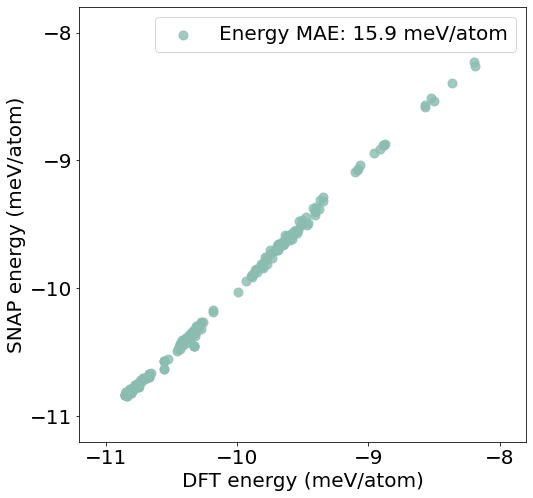

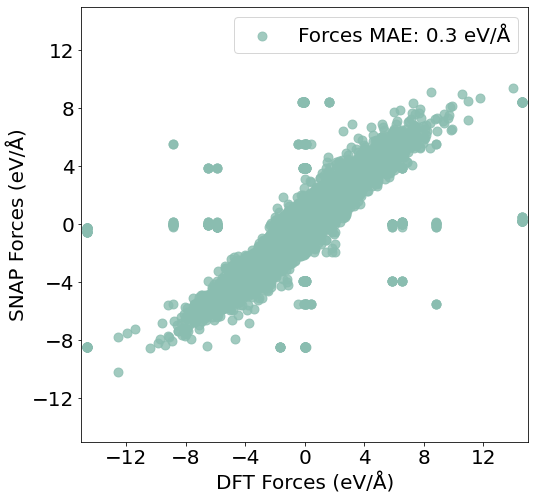

In [7]:
energy_indices = np.argwhere(np.array(df_orig["dtype"]) == "energy").ravel()
forces_indices = np.argwhere(np.array(df_orig["dtype"]) == "force").ravel()
orig = df_orig['y_orig'] / df_orig['n']
predict = df_predict['y_orig'] / df_predict['n']

plt.rc('xtick', labelsize=20)
plt.rc('ytick', labelsize=20)

fig, ax1 = plt.subplots(figsize=(8, 8))
ax1.scatter(orig[energy_indices], predict[energy_indices], color='#8ABDB0', s=80, alpha=0.8, 
            label="Energy MAE: {:.1f} meV/atom".format(mean_absolute_error(orig[energy_indices], predict[energy_indices]) * 1000))
ax1.set_xlim(-11.2, -7.8)
ax1.set_ylim(-11.2, -7.8)
ax1.set_xlabel("DFT energy (meV/atom)", fontsize=20)
ax1.set_ylabel("SNAP energy (meV/atom)", fontsize=20)
ax1.legend(fontsize=20)

from matplotlib import ticker

ax1.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax1.xaxis.set_minor_locator(ticker.MultipleLocator(1))
ax1.yaxis.set_major_locator(ticker.MultipleLocator(1))
ax1.yaxis.set_minor_locator(ticker.MultipleLocator(1))

fig, ax2 = plt.subplots(figsize=(8, 8))
ax2.scatter(orig[forces_indices], predict[forces_indices], color='#8ABDB0', s=80, alpha=0.8,
            label="Forces MAE: {:.1f} eV/Å".format(mean_absolute_error(orig[forces_indices], predict[forces_indices])))
ax2.set_xlim(-15, 15)
ax2.set_ylim(-15, 15)
ax2.set_xlabel("DFT Forces (eV/Å)", fontsize=20)
ax2.set_ylabel("SNAP Forces (eV/Å)", fontsize=20)
ax2.legend(fontsize=20)

ax2.xaxis.set_major_locator(ticker.MultipleLocator(4))
ax2.xaxis.set_minor_locator(ticker.MultipleLocator(4))
ax2.yaxis.set_major_locator(ticker.MultipleLocator(4))
ax2.yaxis.set_minor_locator(ticker.MultipleLocator(4))

### Exercise: SNAP development for Ni-Mo system.

This will take over 10 mins.

In [8]:
Ni_Mo_data = Mo_dopedwith_Ni_data + Ni_dopedwith_Mo_data + Ni3Mo_aimd_data + Ni4Mo_aimd_data + Ni3Mo_elastic_data + Ni4Mo_elastic_data
Ni_Mo_train_structures = [d['structure'] for d in Ni_Mo_data]
Ni_Mo_train_energies = [d['outputs']['energy'] for d in Ni_Mo_data]
Ni_Mo_train_forces = [d['outputs']['forces'] for d in Ni_Mo_data]

Ni_Mo_train_pool = pool_from(Ni_Mo_train_structures, Ni_Mo_train_energies, Ni_Mo_train_forces)
_, Ni_Mo_df = convert_docs(Ni_Mo_train_pool)
weights = np.ones(len(Ni_Mo_df['dtype']), )
weights[Ni_Mo_df['dtype'] == 'energy'] = 10000
weights[Ni_Mo_df['dtype'] == 'force'] = 1

element_profile = {'Ni': {'r': 0.575, 'w': 0.5}, 'Mo': {'r': 0.575, 'w': 1.0}}
describer = BispectrumCoefficients(cutoff=4.6, twojmax=6, 
                                   element_profile=element_profile, quadratic=False, 
                                   pot_fit=True, include_stress=False)

ml_model = LinearRegression()
skl_model = SKLModel(describer=describer, model=ml_model)
Ni_Mo_snap = SNAPotential(model=skl_model)
Ni_Mo_snap.train(Ni_Mo_train_structures, Ni_Mo_train_energies, Ni_Mo_train_forces, sample_weight=weights)

### Predict the basic materials properties

lattice constants prediction. See [LatticeConstants calculator](https://github.com/materialsvirtuallab/maml/blob/master/maml/apps/pes/_lammps.py).

inputs:
 - ff_settings: The potential object. Take SNAPotential as input here.

In [9]:
Mo_cell = Structure.from_spacegroup(sg='Im-3m', species=['Mo'], lattice=Lattice.cubic(3.17), coords=[[0, 0, 0]])

Mo_lc_calculator = LatticeConstant(Mo_snap)
a, b, c = Mo_lc_calculator.calculate([Mo_cell])[0]
print('Mo', 'Lattice a: {:.3f} Å, Lattice b: {:.3f} Å, Lattice c: {:.3f} Å'.format(a, b, c))

Mo Lattice a: 3.146 Å, Lattice b: 3.146 Å, Lattice c: 3.146 Å


elastic constants prediction. See [ElasticConstants calculator](https://github.com/materialsvirtuallab/maml/blob/master/maml/apps/pes/_lammps.py).

Inputs:
 - ff_settings: The potential object
 - lattice: Conventional lattice type e.g., sc -> simple cubic, bcc -> body centered cubic, fcc -> face centered cubic
 - alat: Lattice constants of conventional cell.
 - atom_type: The type of atom evaluted. Fo elemental system, there is no other choice. For binary system (e.g., Ni-Mo), there are two choices (atom1 or atom2).

In [10]:
Mo_ec_calculator = ElasticConstant(ff_settings=Mo_snap, lattice='bcc', alat=3.17, atom_type='Mo')
Mo_C11, Mo_C12, Mo_C44, _ = Mo_ec_calculator.calculate()
print('Mo', ' C11: {:.0f} GPa'.format(Mo_C11), 'C12: {:.0f} GPa'.format(Mo_C12), 'C44: {:.0f} GPa'.format(Mo_C44))

Mo  C11: 487 GPa C12: 296 GPa C44: 75 GPa


nudged elastic band barrier prediction. See [NudgedElasticBand calculator](https://github.com/materialsvirtuallab/maml/blob/master/maml/apps/pes/_lammps.py). Make sure LAMMPS [replica](https://lammps.sandia.gov/doc/Howto_replica.html) subpackage and **mpi** executable are installed.

Inputs:
 - ff_settings: The potential object
 - specie: The type of atom evaluted. Fo elemental system, there is no other choice. For binary system (e.g., Ni-Mo), there are two choices (atom1 or atom2).
 - lattice: Conventional lattice type e.g., sc -> simple cubic, bcc -> body centered cubic, fcc -> face centered cubic
 - alat: Lattice constants of conventional cell.
 
This might cause error on nanohub as it requires the access of MPI executable of lammps (i.e., lmp_mpi). Please contact the administrator.

In [11]:
Mo_neb_calcualtor = NudgedElasticBand(ff_settings=Mo_snap, specie='Mo', lattice='bcc', alat=3.17, lmp_exe="lmp_mpi")
barrier = Mo_neb_calcualtor.calculate()
print('Mo NEB barrier: {:.3f} eV'.format(barrier))

Mo NEB barrier: 1.879 eV


Vacancy formation energy prediction. See [DefectFormation calculator](https://github.com/materialsvirtuallab/maml/blob/master/maml/apps/pes/_lammps.py).

Inputs:
 - ff_settings: The potential object
 - specie: The type of atom evaluted. Fo elemental system, there is no other choice. For binary system (e.g., Ni-Mo), there are two choices (atom1 or atom2).
 - lattice: Conventional lattice type e.g., sc -> simple cubic, bcc -> body centered cubic, fcc -> face centered cubic
 - alat: Lattice constants of conventional cell.

In [12]:
Mo_vacancy_calcualtor = DefectFormation(ff_settings=Mo_snap, specie='Mo', lattice='bcc', alat=3.16)
formation_energy = Mo_vacancy_calcualtor.calculate()
print('Mo Vacancy formation energy: {:.2f} eV'.format(formation_energy))

Mo Vacancy formation energy: 2.52 eV
